# Notebook to make Fig. 5

In [13]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde

import json
import random
import sys
import os

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

from fig_helper_functions import *

style.use('plotting.mplstyle')

### Load data

In [2]:
# Load in the predicted and observed draws 
f_root = '../Data/PopulationInferenceOutput/'
with open(f_root+'pred_vs_obs_spins_dict_pp.json', 'r') as f: 
    pred_vs_obs_spins = json.load(f)

### Calculate slopes of PP plot (Fig 4) for each catalog as a function of predicted spin

Calculate slopes using linear regression

In [3]:
def findSlope(x_values, y_values): 
    
    X = np.asarray([[x, 1] for x in x_values])
    X_T = np.transpose(X)
        
    X_matrix = np.matmul(np.linalg.inv(np.matmul(X_T, X)), X_T)
    
    slope, intercept = np.matmul(X_matrix, y_values)
    
    return slope

In [23]:
# number of trials we want to break all the catalogs into in order to calculate error bars
nTrials = 10 

# dictionary to stores slopes and x-values i n
slopes_dict = {}

# Cycle through populations
for pop_key in ['pop1', 'pop2', 'pop3']: 
    
    print(pop_key)
    slopes_dict_pop = {}
    
    for nevents_key in ['70events', '330events']:
        
        print(nevents_key)
        slopes_dict_nevents = {}
    
        # Cycle through parameters
        for param_key in ['chi1', 'cost1', 'chieff', 'chip']:

            # Array in which to store slopes and corresponding 'x' values
            nCatalogs, nEvents = np.asarray(pred_vs_obs_spins[pop_key][nevents_key]['predicted'][param_key]).shape
            
            nCut = int(nEvents/70 * 4) # amount to cut off from ends for linear regression
            
            if param_key=='chi1' or param_key=='cost1': # combine chi1 + chi2, and cost1 +cost2
                nXVals = 2*nEvents - nCut
            else: 
                nXVals = nEvents - nCut
            slopes = np.zeros((nCatalogs, nXVals))
            x_vals = np.zeros((nCatalogs, nXVals))

            # Cycle through catalogs
            for i in range(nCatalogs): 

                # Sort spins
                if param_key=='chi1' or param_key=='cost1': 
                    # combine chi1 + chi2, and cost1 +cost2
                    pred_spins_arr = np.sort(np.concatenate((pred_vs_obs_spins[pop_key][nevents_key]['predicted'][param_key][i], 
                                                             pred_vs_obs_spins[pop_key][nevents_key]['predicted'][param_key[:-1]+'2'][i])))
                    obs_spins_arr = np.sort(np.concatenate((pred_vs_obs_spins[pop_key][nevents_key]['observed'][param_key][i], 
                                                            pred_vs_obs_spins[pop_key][nevents_key]['observed'][param_key[:-1]+'2'][i])))
                else:
                    pred_spins_arr = np.sort(pred_vs_obs_spins[pop_key][nevents_key]['predicted'][param_key][i])
                    obs_spins_arr = np.sort(pred_vs_obs_spins[pop_key][nevents_key]['observed'][param_key][i])

                # Calculate slopes
                x_vals[i,:] = pred_spins_arr[int(nCut/2):-int(nCut/2)]
                slopes[i,:] = [findSlope(pred_spins_arr[j:j+nCut], 
                                         obs_spins_arr[j:j+nCut]) for j in range(nXVals)]

            # shape into proper form
            slopes_dict_nevents[param_key] = {
                'slopes':np.reshape(slopes, (nTrials, int(nCatalogs/nTrials), nXVals)),
                'x_vals':np.reshape(x_vals, (nTrials, int(nCatalogs/nTrials), nXVals)) 
            }
        
        slopes_dict_pop[nevents_key] = slopes_dict_nevents
        
    slopes_dict[pop_key] = slopes_dict_pop
    
print('Done!')

pop1
70events
330events
pop2
70events
330events
pop3
70events
330events
Done!


Calculate percentages of slopes above versus below 1

In [24]:
percentages_dict = {}

for pop,pop_key in enumerate(['pop1', 'pop2', 'pop3']):
    
    print(pop_key)
    
    percentages_dict_pop = {}
    
    for nevents_key in ['70events', '330events']:
        
        print(nevents_key)
        percentages_dict_nevents = {}
    
        for param_key in ['chi1', 'cost1', 'chieff', 'chip']: 

            # Gets slopes and x vals for this population and parameters
            slopes = slopes_dict[pop_key][nevents_key][param_key]['slopes']
            all_x_vals = slopes_dict[pop_key][nevents_key][param_key]['x_vals']

            # Binning
            all_x = np.concatenate(np.concatenate(all_x_vals))
            xmin = np.min(all_x)
            xmax = np.max(all_x)
            xbins = np.linspace(xmin, xmax, 50)

            # Cycle through trials, each has it's own set of y values
            percentages_all = []

            for j in range(nTrials): 

                all_y = np.concatenate(slopes[j])
                all_x_this = np.concatenate(all_x_vals[j])

                # Calculate fraction in each bin above the line x=1
                percentages = []
                midpoints = []
                for i in np.arange(len(xbins)-1):

                    lower_bound = xbins[i]
                    upper_bound = xbins[i+1]
                    mask = (all_x_this >= lower_bound) & (all_x_this <= upper_bound)
                    x_vals = all_x_this[mask]
                    y_vals = all_y[mask]

                    # percentage of values below y=x, ignoring the points with only a few traces (< 5 % of catalogs)
                    if len(x_vals) >= int(0.05*nCatalogs): 
                        percentages += [sum(y_vals < 1) / len(x_vals)]
                    else: 
                        percentages += [np.inf] # will ignore when averaging

                    # midpoint of bin
                    midpoints += [0.5*(lower_bound+upper_bound)]

                percentages_all.append(percentages)     

            # get mean and std dev across trials
            per_transpose = np.transpose(percentages_all)
            means = np.zeros(len(midpoints))
            stds = np.zeros(len(midpoints))
            for i in np.arange(len(midpoints)): 
                mask = (per_transpose[i] != np.inf)
                per = per_transpose[i][mask]
                means[i] = np.mean(per)
                stds[i] = np.std(per)

            # make dict
            percentages_dict_nevents[param_key] = {'percentages':means, 'error':stds, 'x_vals':np.asarray(midpoints)}
        
        percentages_dict_pop[nevents_key] = percentages_dict_nevents
        
    percentages_dict[pop_key] = percentages_dict_pop
    
print('Done!')

pop1
70events
330events
pop2
70events
330events
pop3
70events
330events
Done!


### Make figure

In [25]:
# Labels corresponding to each pop
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '70events':'#d0856a', 
    '330events':'#B13306', 
}

# For legend
legend_handles = [Line2D([], [], color=c, label=l[:-6]+' '+l[-6:]) for l,c in nevents_colors_dict.items()]

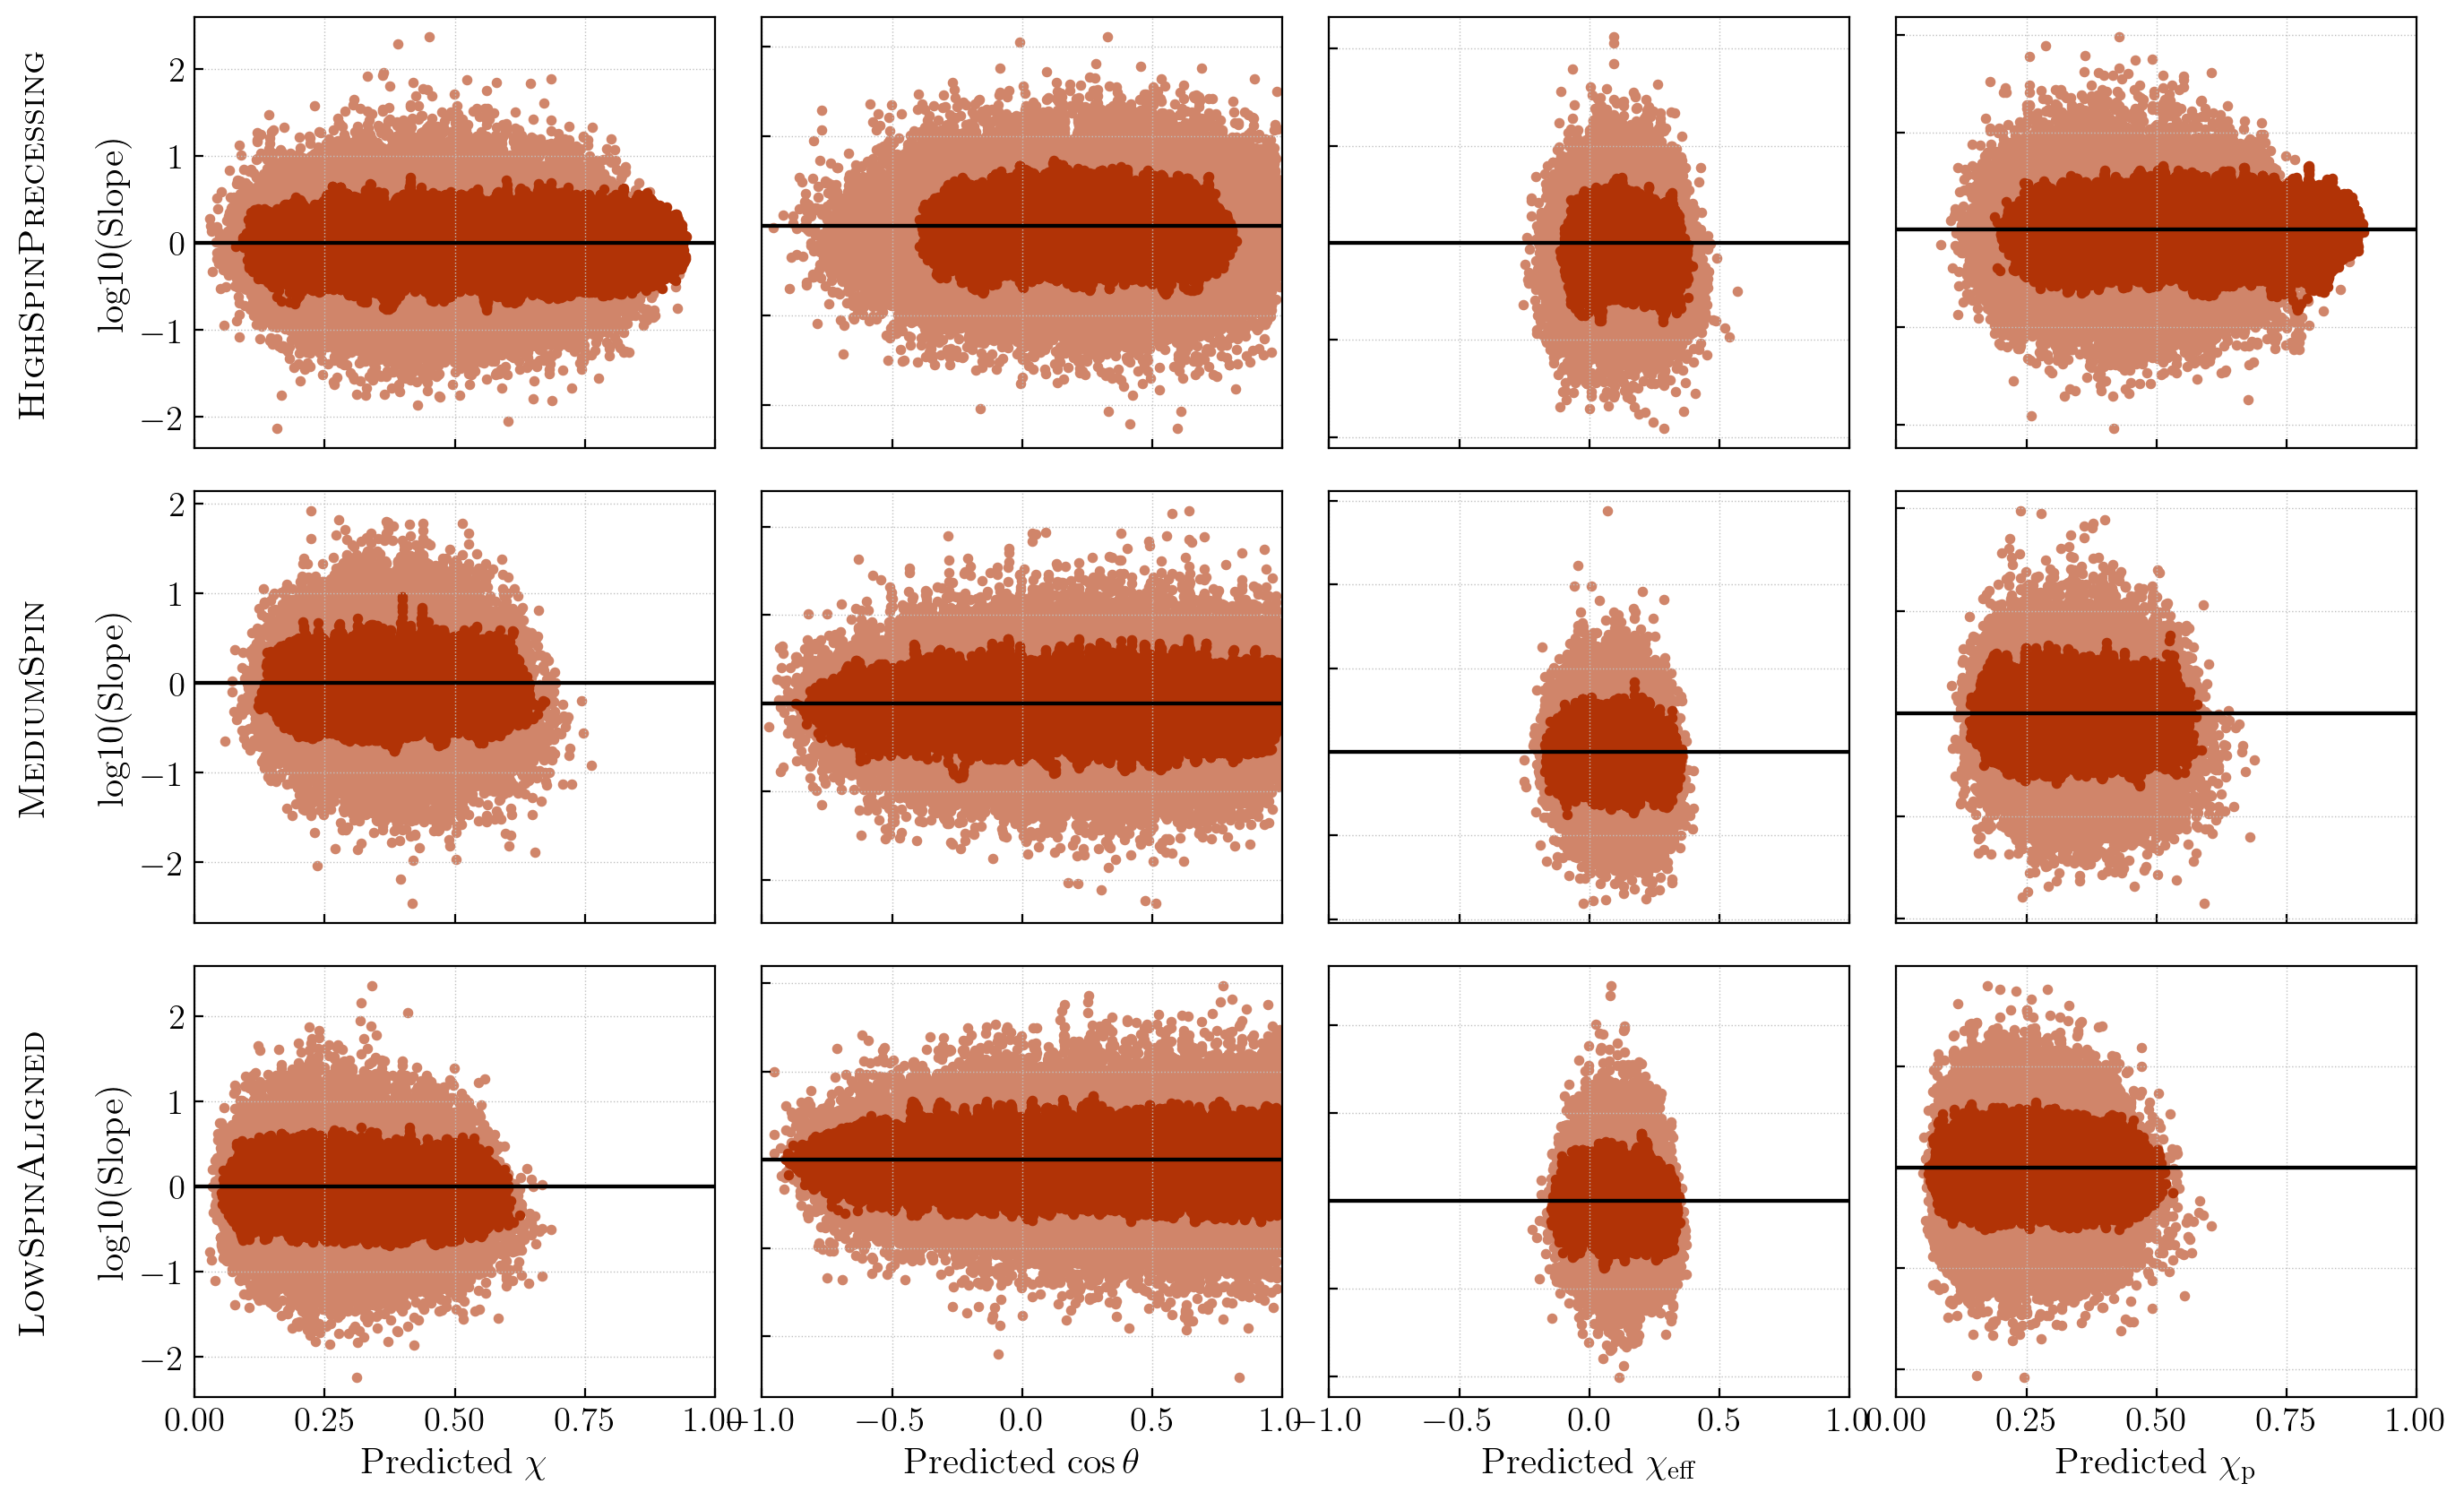

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(labels_dict.keys()):
    
    for nevents_key in nevents_colors_dict.keys():
    
        # spin magnitudes
        axes[i][0].scatter(slopes_dict[key][nevents_key]['chi1']['x_vals'], 
                           np.log10(slopes_dict[key][nevents_key]['chi1']['slopes']), s=10, 
                           color=nevents_colors_dict[nevents_key])
        axes[i][0].plot([0, 1], [0, 0], color='k') # horizontal line
        axes[i][0].set_xlim(0,1)
        #axes[i][0].set_ylim(0,1)

        # tilt angles
        axes[i][1].scatter(slopes_dict[key][nevents_key]['cost1']['x_vals'], 
                           np.log10(slopes_dict[key][nevents_key]['cost1']['slopes']), s=10, 
                           color=nevents_colors_dict[nevents_key])
        axes[i][1].plot([-1, 1], [0, 0], color='k')
        axes[i][1].set_xlim(-1,1)
        #axes[i][1].set_ylim(0,1)

        # chi eff
        axes[i][2].scatter(slopes_dict[key][nevents_key]['chieff']['x_vals'], 
                           np.log10(slopes_dict[key][nevents_key]['chieff']['slopes']), s=10, 
                           color=nevents_colors_dict[nevents_key])
        axes[i][2].plot([-1, 1], [0, 0], color='k')
        axes[i][2].set_xlim(-1,1)
        #axes[i][2].set_ylim(0,1)

        # chi p
        axes[i][3].scatter(slopes_dict[key][nevents_key]['chip']['x_vals'], 
                           np.log10(slopes_dict[key][nevents_key]['chip']['slopes']), s=10, 
                           color=nevents_colors_dict[nevents_key])
        axes[i][3].plot([0, 1], [0, 0], color='k')
        axes[i][3].set_xlim(0,1)
        #axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n log10(Slope)', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Predicted $\chi$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)
    
plt.show()

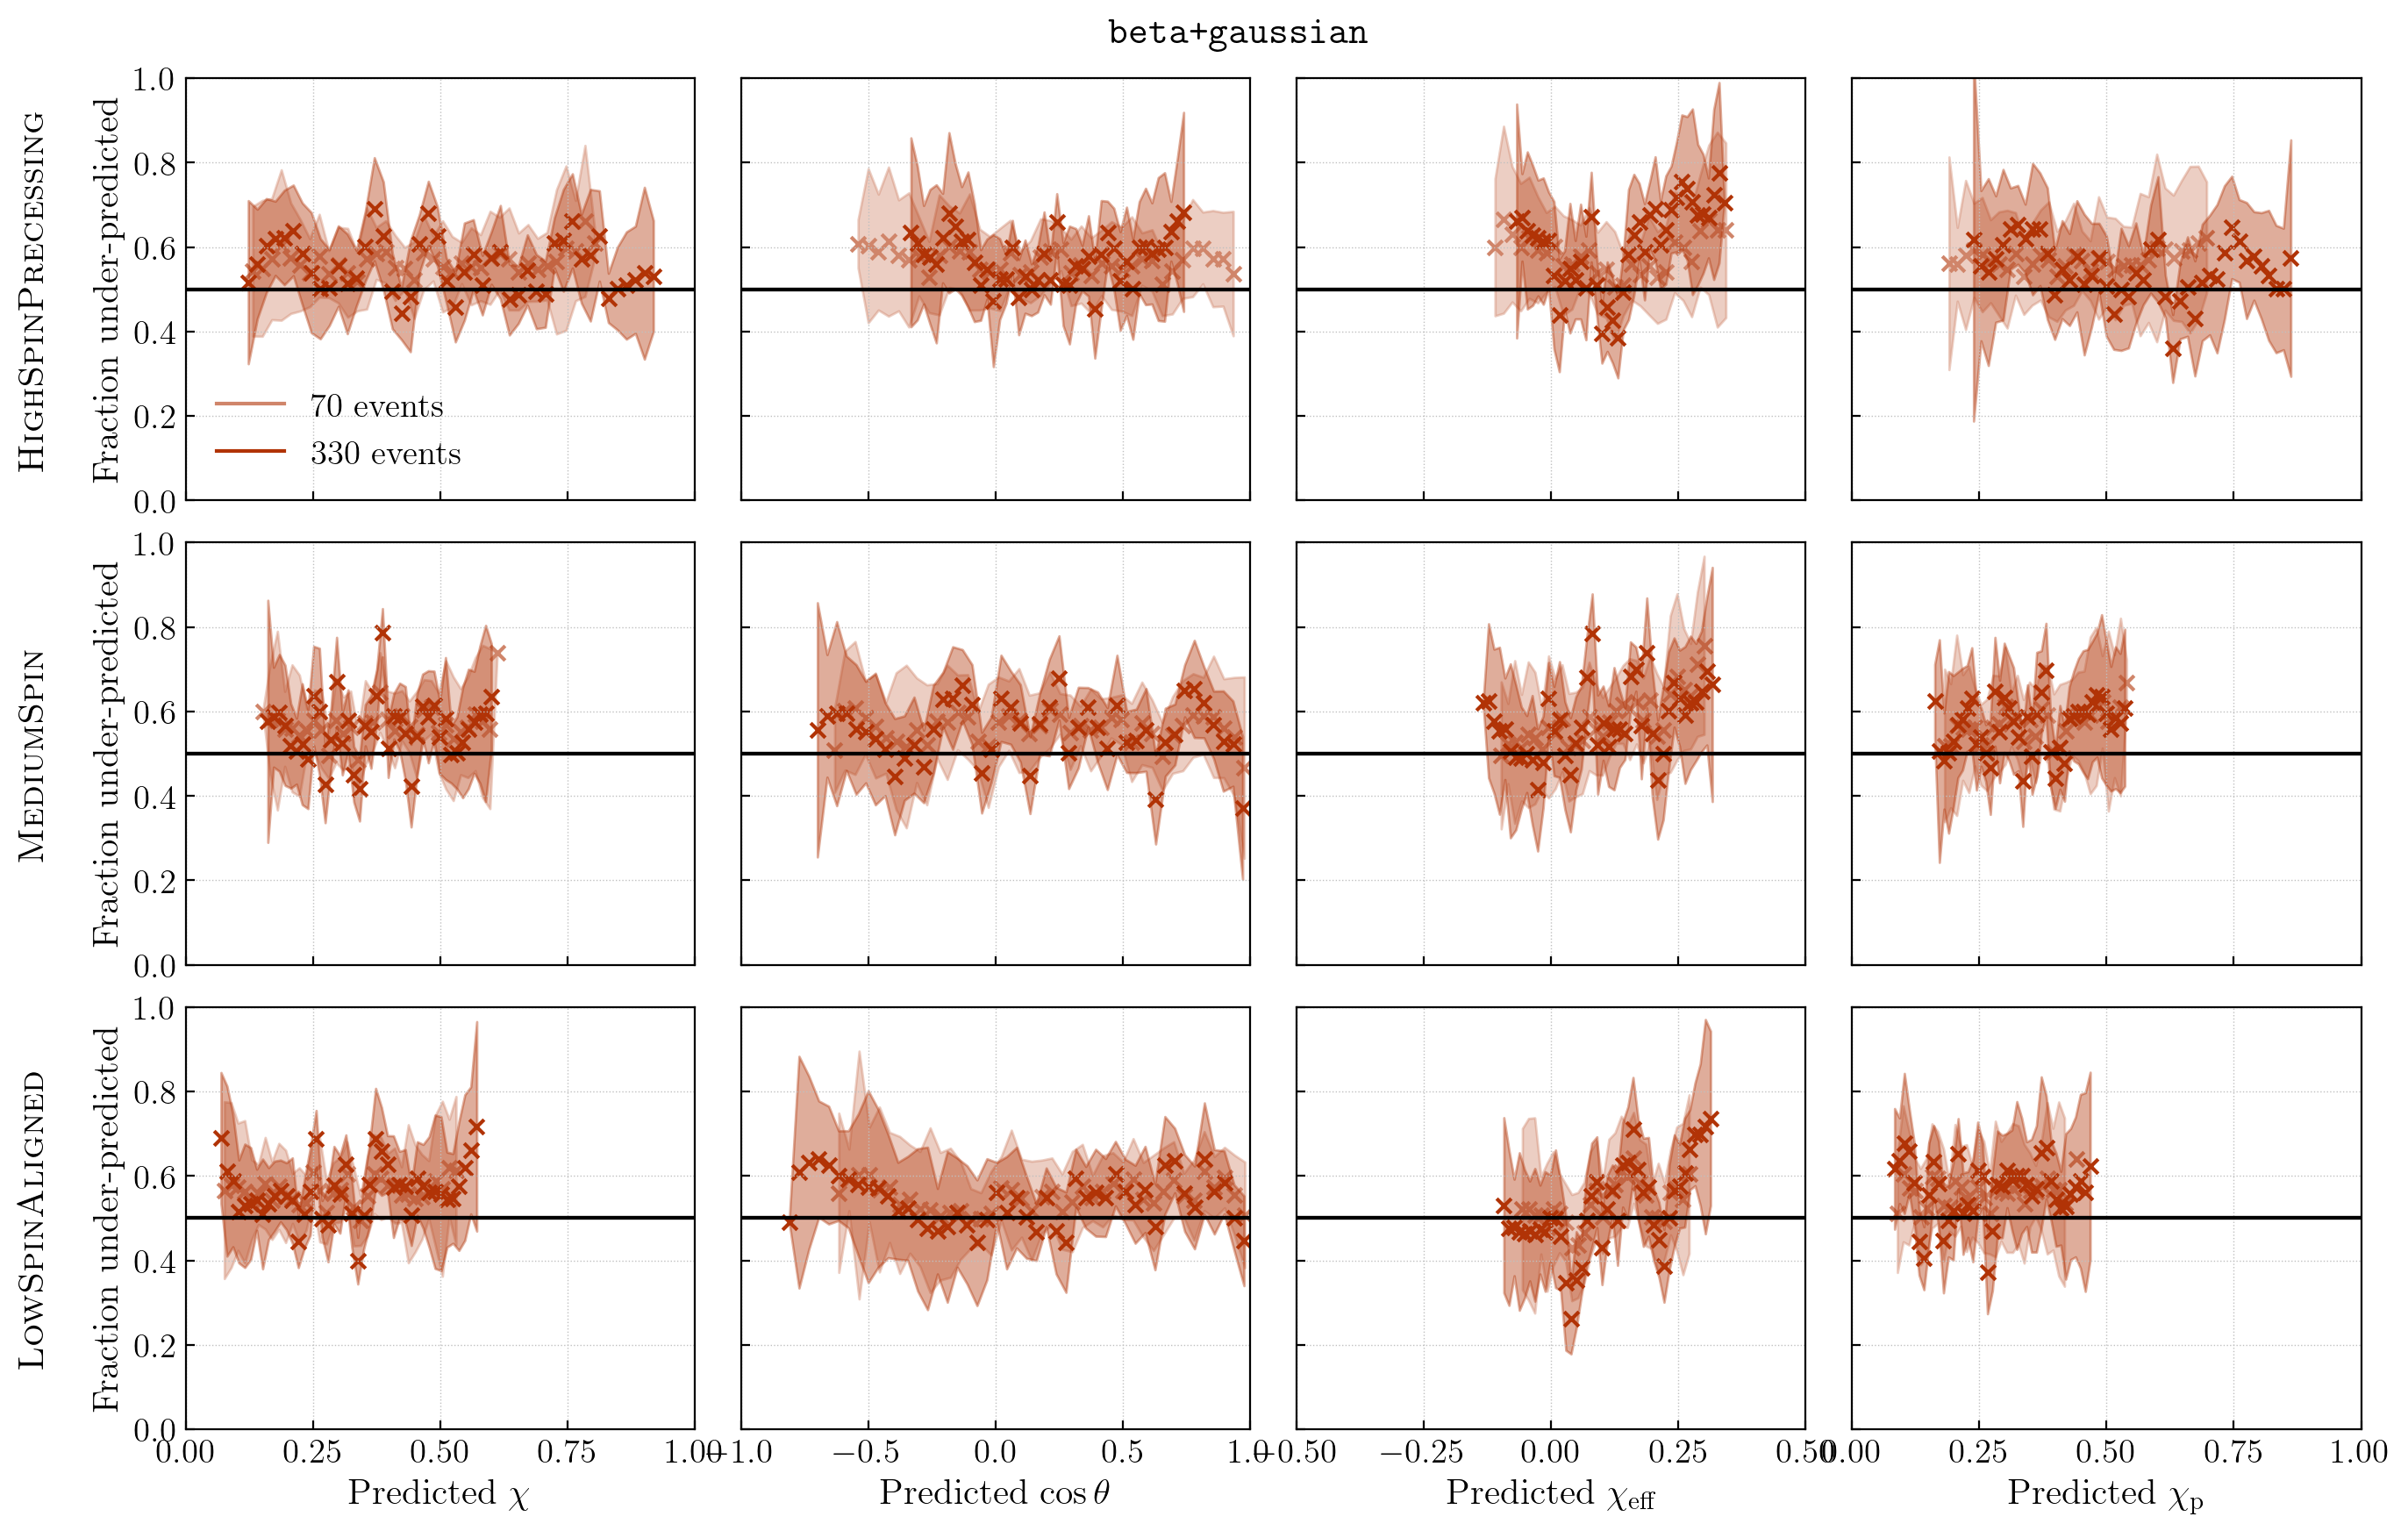

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for i,key in enumerate(labels_dict.keys()):
    
    for nevents_key in nevents_colors_dict.keys():
    
        # spin magnitudes
        axes[i][0].scatter(percentages_dict[key][nevents_key]['chi1']['x_vals'], 
                           percentages_dict[key][nevents_key]['chi1']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        axes[i][0].fill_between(percentages_dict[key][nevents_key]['chi1']['x_vals'], 
                    percentages_dict[key][nevents_key]['chi1']['percentages']+3*percentages_dict[key][nevents_key]['chi1']['error'], 
                    percentages_dict[key][nevents_key]['chi1']['percentages']-3*percentages_dict[key][nevents_key]['chi1']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        axes[i][0].plot([0, 1], [0.5, 0.5], color='k') # horizontal line
        axes[i][0].set_xlim(0,1)
        axes[i][0].set_ylim(0,1)

        # tilt angles
        axes[i][1].scatter(percentages_dict[key][nevents_key]['cost1']['x_vals'], 
                           percentages_dict[key][nevents_key]['cost1']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        axes[i][1].fill_between(percentages_dict[key][nevents_key]['cost1']['x_vals'], 
                    percentages_dict[key][nevents_key]['cost1']['percentages']+3*percentages_dict[key][nevents_key]['cost1']['error'], 
                    percentages_dict[key][nevents_key]['cost1']['percentages']-3*percentages_dict[key][nevents_key]['cost1']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        axes[i][1].plot([-1, 1], [0.5, 0.5], color='k')
        axes[i][1].set_xlim(-1,1)
        axes[i][1].set_ylim(0,1)

        # chi eff
        axes[i][2].scatter(percentages_dict[key][nevents_key]['chieff']['x_vals'], 
                           percentages_dict[key][nevents_key]['chieff']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        axes[i][2].fill_between(percentages_dict[key][nevents_key]['chieff']['x_vals'], 
                    percentages_dict[key][nevents_key]['chieff']['percentages']+3*percentages_dict[key][nevents_key]['chieff']['error'], 
                    percentages_dict[key][nevents_key]['chieff']['percentages']-3*percentages_dict[key][nevents_key]['chieff']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        axes[i][2].plot([-1, 1], [0.5, 0.5], color='k')
        axes[i][2].set_xlim(-0.5,0.5)
        axes[i][2].set_ylim(0,1)

        # chi p
        axes[i][3].scatter(percentages_dict[key][nevents_key]['chip']['x_vals'], 
                           percentages_dict[key][nevents_key]['chip']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        axes[i][3].fill_between(percentages_dict[key][nevents_key]['chip']['x_vals'], 
                    percentages_dict[key][nevents_key]['chip']['percentages']+3*percentages_dict[key][nevents_key]['chip']['error'], 
                    percentages_dict[key][nevents_key]['chip']['percentages']-3*percentages_dict[key][nevents_key]['chip']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        axes[i][3].plot([0, 1], [0.5, 0.5], color='k')
        axes[i][3].set_xlim(0,1)
        axes[i][3].set_ylim(0,1)
    
    # set label
    axes[i][0].set_ylabel(f'{labels_dict[key]}\n\n Fraction under-predicted', fontsize=15)
        
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])
    
axes[2][0].set_xlabel(r'Predicted $\chi$', fontsize=15)
axes[2][1].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
axes[2][2].set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
axes[2][3].set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

for ax in axes: 
    for i,a in enumerate(ax):
        a.grid(ls=':', color='silver', lw=0.5)
        if i!=0: 
            a.set_yticklabels([])
        
plt.subplots_adjust(hspace=0.1, wspace=0.09)

plt.suptitle(r'$\mathrm{\texttt{beta+gaussian}}$', fontsize=16, y=0.915)

# Add legend
axes[0][0].legend(handles=legend_handles, loc='lower left')
    
plt.savefig('figure_05_temp.pdf',bbox_inches='tight')
plt.show()